In [1]:
from nutils import *
import numpy, unittest

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections

In [2]:
nelems = 2
degree = 1
tol  = 1e-5
ndims = 1
extent = 1
v = 0    # convective velocity
k = 1      # diffusivity

In [3]:
domain, geom = mesh.rectilinear([numpy.linspace(0,extent,nelems+1)]*ndims)

In [4]:
# prepare residual
ns = function.Namespace()
ns.pi = numpy.pi
ns.x = geom
ns.basis = domain.basis('lagrange', degree=degree)
ns.u = 'basis_n ?lhs_n'
ns.k = k
ns.v = v
h = extent / nelems
# Put element length in namespace
ns.h = h

# Tuning parameters
ns.beta = 1
ns.gamma = 10

# DG Stabilization parameters (all the same for an equidistant mesh)
ns.tauZero = ' gamma k / h'
ns.tauN    = ' gamma k / h'
ns.tauA    = ' gamma k / h'

# SUPG stabilization parameter
if(numpy.exp(v/k) == float('inf')):
    ns.tau = ' h / (2 v)'
else:
    ns.peclet = ' 0.5 v h / k'
    ns.tau = ' ((cosh(peclet) / sinh(peclet)) - (1 / peclet)) h / (2 v) '
    
# Advection Upwinding coefficient
ns.C = ' v '   
ns.ext = extent

# BCs and analytical solution
#ns.z = 2
#ns.gl  = 'cos( z pi x_0 )'
#ns.gr  = 'cos( z pi x_0 )'
#ns.dgl = '-(z pi) sin( z pi x_0 )'
#ns.dgr = '-(z pi) sin( z pi x_0 )'
#ns.ddg = '-(z pi)^2 cos( z pi x_0 )'

#ns.f   = ' - ddg'

# u(x) = [(gr-gl)/(exp(v/k) - 1)] [exp((v/k) x) - 1] + gl
# u'(x)= (v/k)[(gr-gl)/(exp(v/k) - 1] [exp((v/k) x)]
#   with u(0) = gl, u(extent) = gr 
ns.f = 0
ns.gl = 1
ns.gr = 0
# Catch potential overflow exceptions
if(numpy.exp(v/k) == float('inf')):
    # exp(v/k) -> infinity (triggers overflow exception)
    # Find expression for ns.g
    pass
else:
    ns.analytical = '( (gr - gl) / (exp(v / k) - 1) ) (exp( (v / k) x_0) - 1) + gl'

In [5]:
# construct residual
# Element integrals
# Diffusive part and RHS
res = domain.integral('k basis_n,0 u_,0 - basis_n f' @ ns, geometry=ns.x, degree=degree*2)
# Advective part
res += domain.integral('-v basis_n,0 u' @ ns, geometry=ns.x, degree=5)
# SUPG stabilized part
res += domain.integral(' tau v basis_n,0 (v u_,0 - k (u_,0)_,0 - f )' @ ns, geometry=ns.x, degree=5)

# Interface integrals
# Diffusive part
#    part one                      |
#                                  v  minus might be necessary here because of jump definitions (likewise on second +)
res += domain.interfaces.integral(' [basis_n] n_0 k {u_,0} + beta k {basis_n,0} [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
res += domain.interfaces.integral(' tauA [basis_n] n_0 [u] n_0' @ ns, geometry=ns.x, degree=degree*2)
# Advective part
res += domain.interfaces.integral('- v [basis_n] n_0 ({u} - .5 C [u] n_0)' @ ns, geometry=ns.x, degree=5)

# Boundary integrals LHS
#    part one
res += domain.boundary.integral('- k basis_n u_,0 + beta k basis_n,0 u ' @ ns, geometry=ns.x, degree=degree*2)
#    part two (stabilized)
res += domain.boundary['left'].integral(' tauZero basis_n u ' @ ns, geometry=ns.x, degree=degree*2)
res += domain.boundary['right'].integral(' tauN basis_n u ' @ ns, geometry=ns.x, degree=degree*2)

# Boundary integrals RHS (weakly imposed boundary conditions) (including stabilization)
# Diffusive part
res -= domain.boundary['left'].integral(' ( beta k basis_n,0 + tauZero basis_n) gl ' @ ns, geometry=ns.x, degree=degree*2)
res -= domain.boundary['right'].integral(' ( beta k basis_n,0 + tauN basis_n) gr ' @ ns, geometry=ns.x, degree=degree*2)
# Advective part
res += domain.boundary['left'].integral('v basis_n n_0 (0.5 (gl + u) - .5 C (gl - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)
res += domain.boundary['right'].integral('v basis_n n_0 (0.5 (gr + u) - .5 C (gr - u) n_0)' @ ns, geometry=ns.x, degree=degree*2)

In [6]:
# find lhs such that res == 0 and substitute this lhs in the namespace
# lhs = solver.solve_linear('lhs', res, constrain=cons)
lhs = solver.solve_linear('lhs', res)
ns = ns(lhs=lhs)

Here comes the Jacobian
(3, 3)
[[  2.20000000e+01  -4.00000000e+00   0.00000000e+00]
 [  4.44089210e-16   4.00000000e+00  -4.00000000e+00]
 [  0.00000000e+00   4.44089210e-16   2.20000000e+01]]
[-18.  -2.   0.]
solve > solver returned with residual 0e+00


<Figure size 432x288 with 0 Axes>

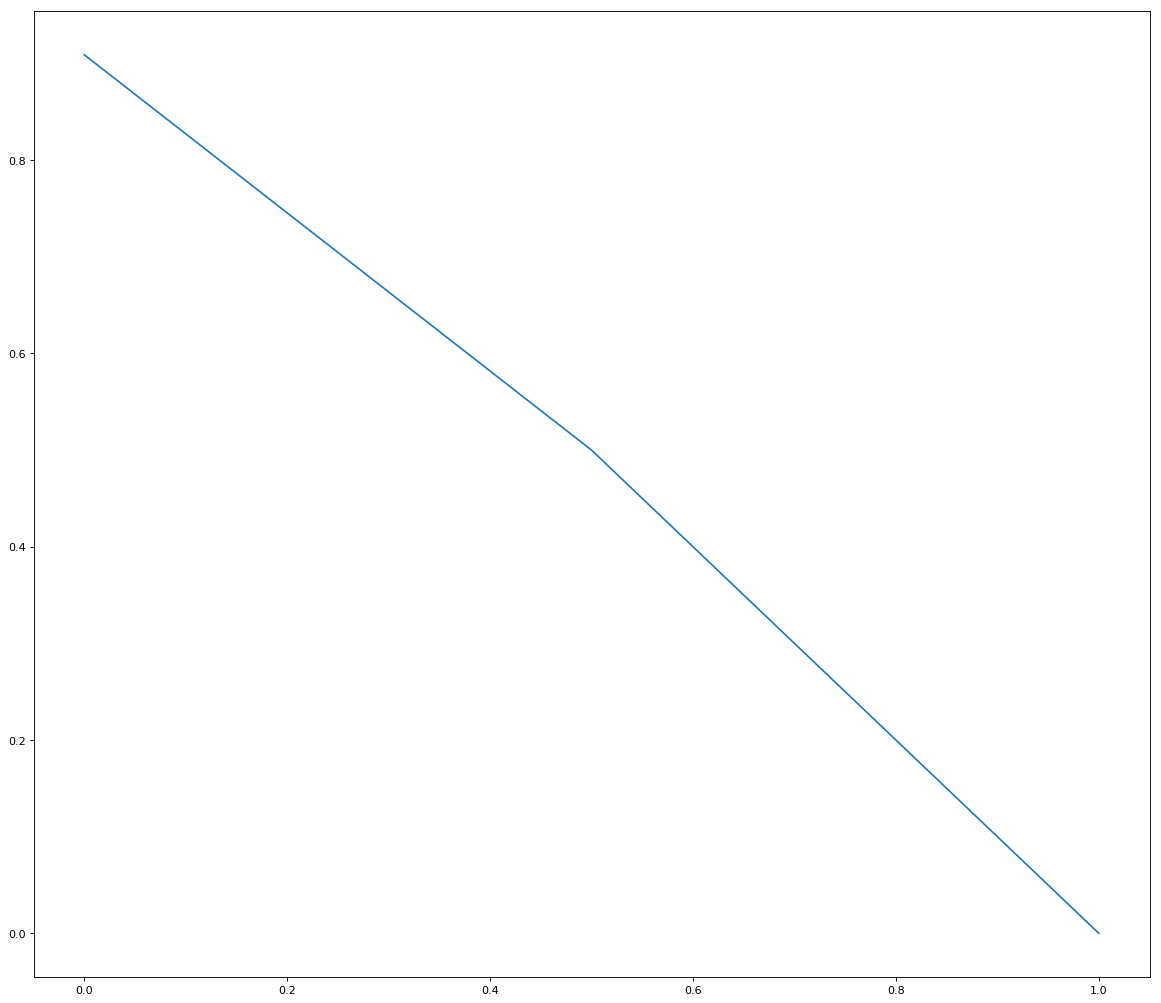

In [7]:
# plot solution
plt.figure()
bezier = domain.sample('bezier', 9)
x, u = bezier.eval([ns.x, ns.u])
#x, analytical = bezier.eval([ns.x, ns.analytical])
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x, u)
#plt.plot(x, analytical, 'r')
# plt.ylim(-2,2)